In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 80)



In [50]:
df = pd.read_csv("listings.csv")

# as we don't expect tp fetch picture or processing text for this analysis, we can drop columns that are not relevant
# neighborhood has too many na
df['have_description'] = df['description'].notnull()
df['have_nhoverview'] = df['neighborhood_overview'].notnull()
df['have_host_about'] = df['host_about'].notnull()
df['license'] = df['license'].notnull()
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '', regex=False)
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce') / 100
df['price'] = df['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce') # Coerce errors will turn invalid parsing into NaN
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')


col_to_drop = (
    df.columns.str.contains('url') |
    (df.columns == 'description') |
    (df.columns == 'host_about') |
    (df.columns == 'calendar_updated') |
    (df.columns == 'license') |
    df.columns.str.contains('name') |
    df.columns.str.contains('scrape') |
    df.columns.str.contains('maximum_minimum') |
    df.columns.str.contains('minimum_minimum') |
    df.columns.str.contains('nights_avg') |
    # all neighborhood column except neighbourhood_group_cleansed
    (df.columns.str.contains('neighbourhood') & ~(df.columns == 'neighbourhood_group_cleansed'))
)
df = df.loc[:, ~col_to_drop]
print(df.info())
# print(df.describe(include='all'))
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13945 entries, 0 to 13944
Data columns (total 61 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            13945 non-null  int64         
 1   source                                        13945 non-null  object        
 2   neighborhood_overview                         6612 non-null   object        
 3   host_id                                       13945 non-null  int64         
 4   host_since                                    13917 non-null  datetime64[ns]
 5   host_location                                 11241 non-null  object        
 6   host_response_time                            8807 non-null   object        
 7   host_response_rate                            8807 non-null   float64       
 8   host_acceptance_rate                          9567 non-null   obje

,id,source,neighborhood_overview,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_maximum_nights,maximum_maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,have_description,have_nhoverview,have_host_about
0,3176,city scrape,The neighbourhood is famous for its variety of...,3718,2008-10-19,"Coledale, Australia",within a day,0.67,40%,f,1.0,1.0,"['email', 'phone']",t,t,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,2.0,"[""Bathtub"", ""Dishes and silverware"", ""Bed line...",105.0,63,730,730.0,730.0,t,0,0,11,286,149,1,1,212,0,126,13230.0,2009-06-20,2025-03-02,4.63,4.67,4.52,4.65,4.70,4.92,4.61,f,1,1,0,0,0.78,True,True,True
1,9991,city scrape,Prenzlauer Berg is an amazing neighbourhood wh...,33852,2009-08-25,"Berlin, Germany",a few days or more,0.00,0%,f,1.0,1.0,"['email', 'phone']",t,t,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,2.5,2.5 baths,4.0,4.0,"[""Bathtub"", ""Dryer"", ""Dishes and silverware"", ...",135.0,6,14,14.0,14.0,t,0,0,0,109,7,0,0,35,0,0,0.0,2015-08-09,2020-01-04,5.00,5.00,5.00,5.00,5.00,4.86,4.86,f,1,1,0,0,0.06,True,True,True
2,14325,city scrape,NaN,55531,2009-11-18,"Berlin, Germany",within a few hours,1.00,38%,t,4.0,5.0,"['email', 'phone', 'work_email']",t,t,Pankow,52.54813,13.40366,Entire rental unit,Entire home/apt,1,1.0,1 bath,0.0,1.0,"[""Heating"", ""Host greets you"", ""Smoke alarm"", ...",75.0,150,1125,1125.0,1125.0,t,0,0,0,165,26,0,0,91,0,0,0.0,2010-06-29,2023-11-30,4.68,5.00,4.85,4.70,4.85,4.60,4.45,f,4,4,0,0,0.15,True,False,True
3,16644,city scrape,Our Part of Kreuzberg is just the best. Good v...,64696,2009-12-20,"Santa Cruz, CA",NaN,NaN,0%,f,4.0,4.0,"['email', 'phone']",t,t,Friedrichshain-Kreuzberg,52.50312,13.43508,Entire condo,Entire home/apt,4,1.0,1 bath,1.0,1.0,"[""Heating"", ""Room-darkening shades"", ""Children...",77.0,93,365,365.0,365.0,t,0,0,0,196,48,0,0,122,0,0,0.0,2010-06-04,2017-12-14,4.72,4.86,4.86,4.93,4.86,4.67,4.71,f,2,2,0,0,0.27,True,True,True
4,17904,city scrape,"The apartment is located in Kreuzberg, which i...",68997,2010-01-08,"Rio de Janeiro, Brazil",within an hour,1.00,95%,f,2.0,5.0,"['email', 'phone']",t,t,Neukölln,52.49419,13.42166,Entire rental unit,Entire home/apt,2,1.0,1 bath,0.0,1.0,"[""Dishes and silverware"", ""Luggage dropoff all...",40.0,92,365,365.0,365.0,t,0,0,0,29,299,0,0,29,0,0,0.0,2010-02-18,2022-12-01,4.77,4.82,4.71,4.89,4.92,4.87,4.65,f,1,1,0,0,1.63,True,True,True


In [4]:
#seperate the df into who have full reviews and who have no/missing reviews
review_cols = [col for col in df.columns if col.startswith('review_')]
df['review'] = np.where(df[review_cols].isnull().any(axis=1), 'missing', 'present')



In [5]:
#review missing due to not renting out/new listings
df[df['review'] == 'missing'].estimated_occupancy_l365d.sum()

np.int64(0)

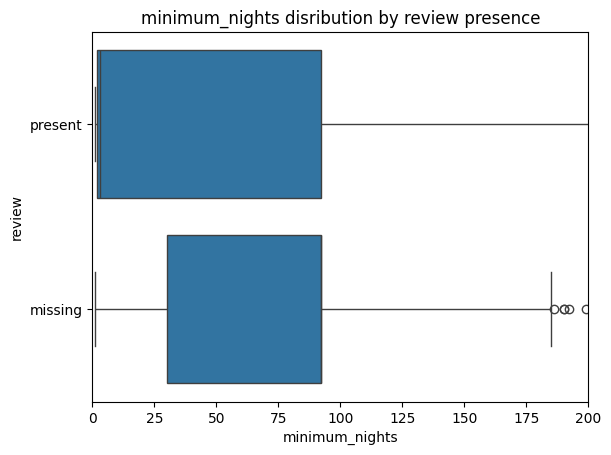

In [6]:
#looks like longer minimum nights have reduce chance of renting out
sns.boxplot(data=df, x="minimum_nights", y="review")
plt.xlim(0, 200)  
plt.title('minimum_nights disribution by review presence')
plt.show()

Text(0.5, 1.0, 'Relation of minimum_nights and estimated occupancy')

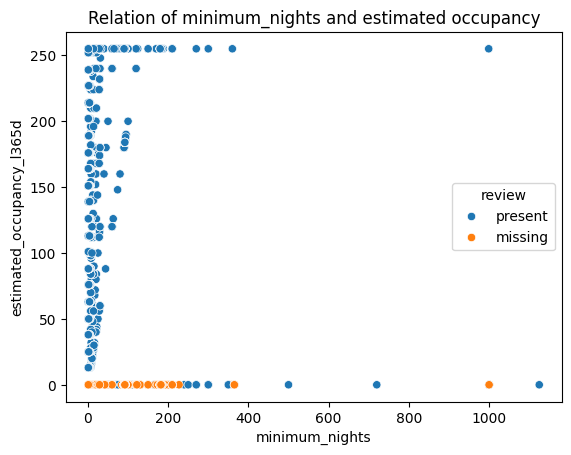

In [7]:
sns.scatterplot(data=df, x="minimum_nights", y="estimated_occupancy_l365d", hue="review")
plt.title('Relation of minimum_nights and estimated occupancy')


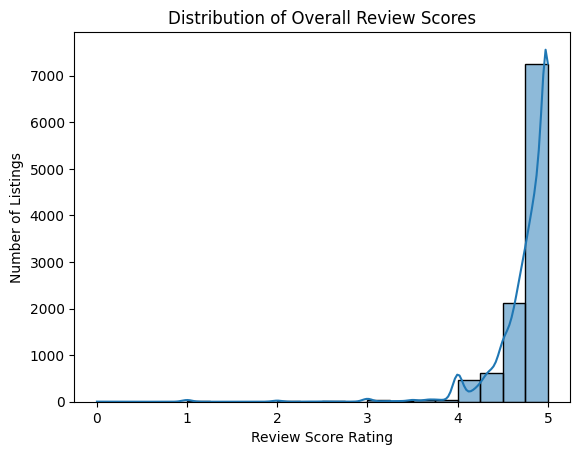

In [8]:
sns.histplot(df['review_scores_rating'].dropna(), kde=True, bins=20)
plt.title('Distribution of Overall Review Scores')
plt.xlabel('Review Score Rating')
plt.ylabel('Number of Listings')
plt.show()

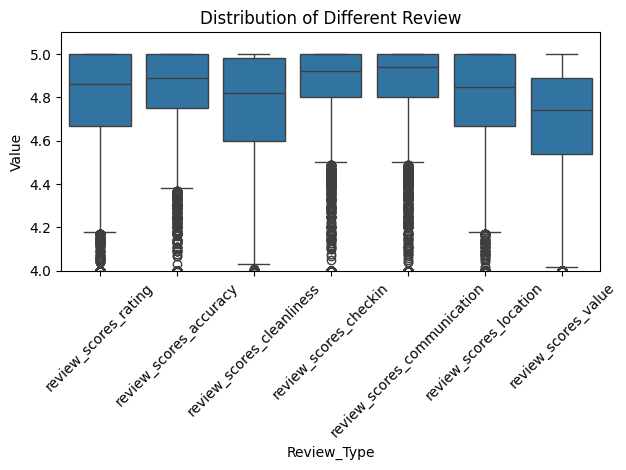

In [9]:
#https://www.airbnb.de/help/article/1257?_set_bev_on_new_domain=1753653926_EAY2MwODQ0MGUwNm
#accuracy, check in, communication loose, cleanliness, value strict, location neutral
df_melted = df[review_cols].melt(var_name='Review_Type', value_name='Value')


sns.boxplot(data=df_melted, x='Review_Type', y='Value')
plt.xticks(rotation=45)
plt.ylim(4, 5.1)  
plt.title('Distribution of Different Review')
plt.tight_layout()
plt.show()



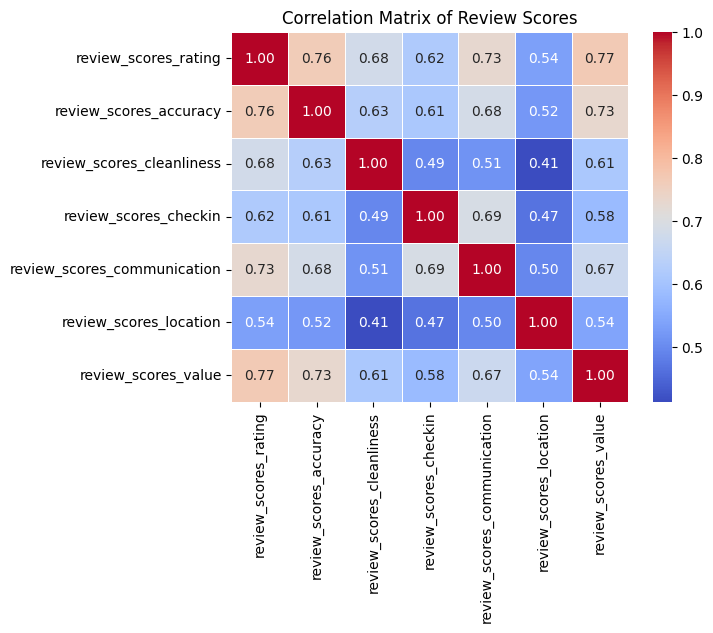

In [10]:
# top 3 are value, accuracy, communication
correlation_matrix = df[review_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Review Scores')
plt.show()

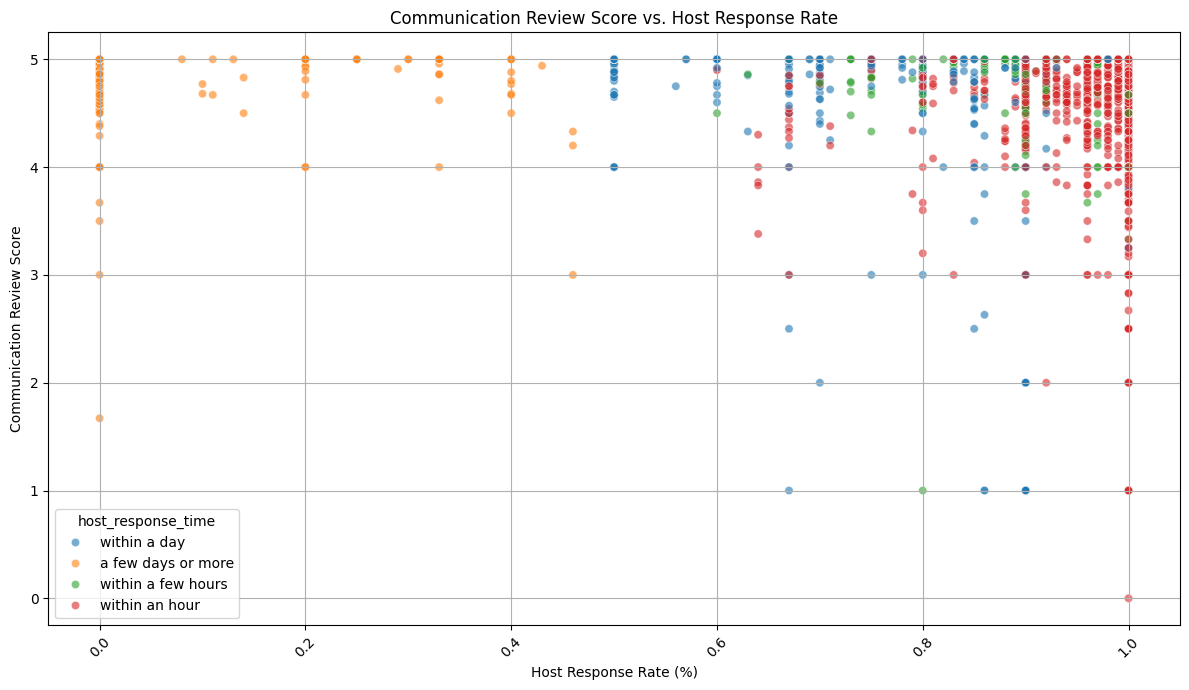

In [ ]:
# showing sign of threashold effect, Guests might expect a minimum level of responsiveness, as long as it's met, extra effort yields diminishing returns.
#host's response rate = new inquiries and reservation requests they respond to within 24 hours. This includes both accepting/pre-approving or declining messages. If a host receives fewer than 10 message threads in the past 30 days, the rate is based on the 10 most recent threads from the past 90 days. 
# host who takes days to respond doesn't imply a low score
# some host who reply within an hour have a low score, this shows rating is more related to communication content instead of speed 
# https://www.airbnb.com/help/article/430
plt.figure(figsize=(12, 7))
sns.scatterplot(x='host_response_rate', y='review_scores_communication', data=df, hue='host_response_time', alpha=0.6)
plt.title('Communication Review Score vs. Host Response Rate')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Communication Review Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

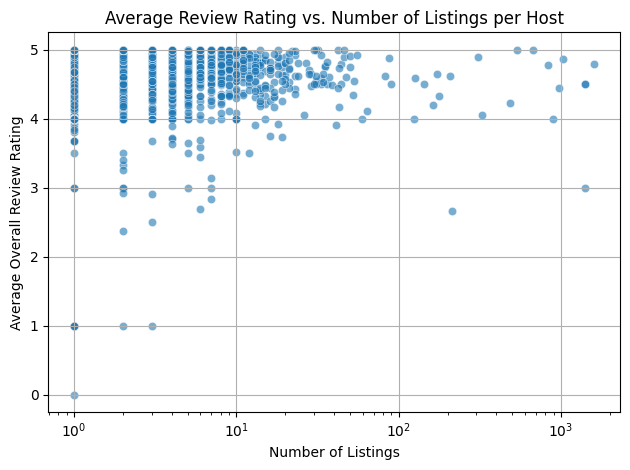

In [ ]:
# Relationship between number of listings a host manages and their average review rating, seems like private host and entriprise both have good and bad performance
# average rating per host (if they have multiple listings)
host_avg_ratings = df.groupby('host_id').agg(
    avg_review_rating=('review_scores_rating', 'mean'),
    num_listings=('host_total_listings_count', 'first') # Assuming host_total_listings_count is consistent per host_id
).reset_index()

sns.scatterplot(x='num_listings', y='avg_review_rating', data=host_avg_ratings, alpha=0.6)
plt.title('Average Review Rating vs. Number of Listings per Host')
plt.xlabel('Number of Listings')
plt.ylabel('Average Overall Review Rating')
plt.xscale('log') # Use log scale as num_listings can vary widely
plt.grid(True)
plt.tight_layout()
plt.show()

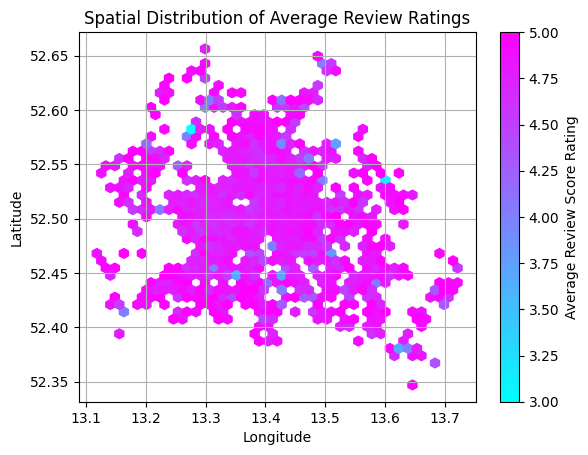

In [14]:

hb = plt.hexbin(
    x=df['longitude'],
    y=df['latitude'],
    C=df['review_scores_rating'],
    reduce_C_function=np.mean,
    gridsize=40,
    cmap='cool'
)

plt.colorbar(hb, label='Average Review Score Rating')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Average Review Ratings')
plt.grid(True)
plt.show()


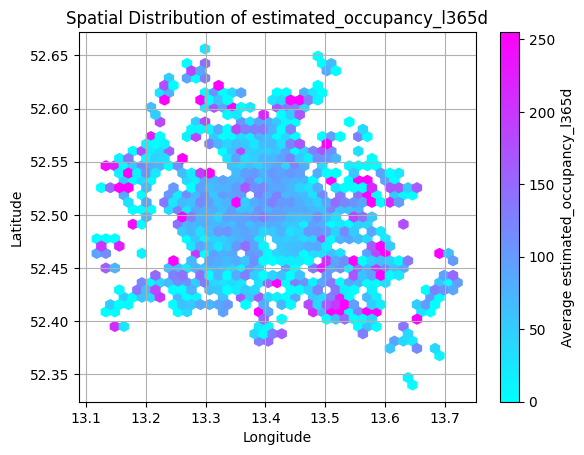

In [15]:

hb = plt.hexbin(
    x=df['longitude'],
    y=df['latitude'],
    C=df['estimated_occupancy_l365d'],
    reduce_C_function=np.mean,
    gridsize=40,
    cmap='cool'
)

plt.colorbar(hb, label='Average estimated_occupancy_l365d')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of estimated_occupancy_l365d')
plt.grid(True)
plt.show()

(0.0, 365.0)

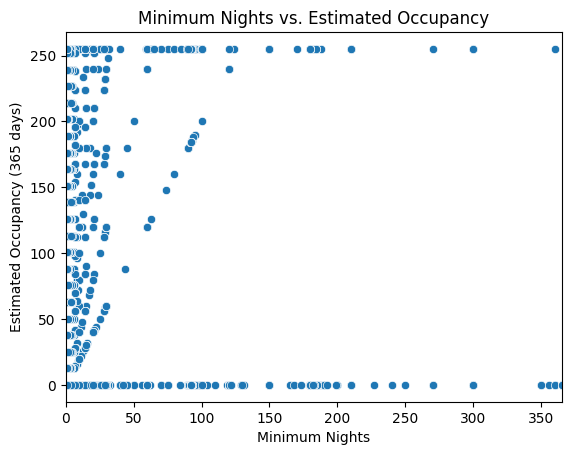

In [ ]:
# looking like minimum_nights is one of the factor that affect estimated_occupancy_l365d
sns.scatterplot(x='minimum_nights', y='estimated_occupancy_l365d', data=df)
plt.title('Minimum Nights vs. Estimated Occupancy')
plt.xlabel('Minimum Nights')
plt.ylabel('Estimated Occupancy (365 days)')
plt.xlim(0, 365)  # Limit x-axis to focus on lower minimum nights

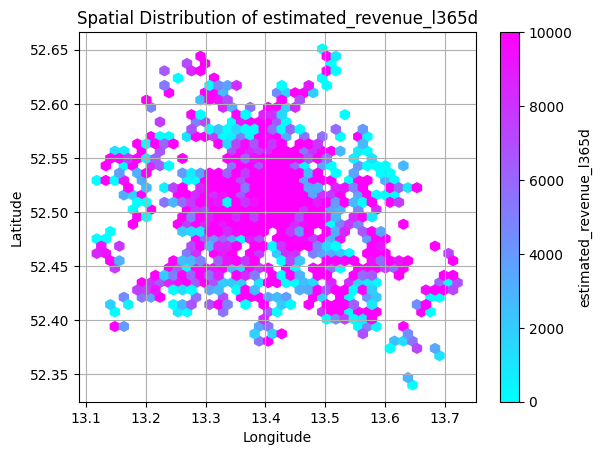

In [16]:
# looks like revenue estimation have strong outliers
df_drop_revenue_outlier = df[df['estimated_revenue_l365d'] <= 300000]  # Adjust threshold as needed

hb = plt.hexbin(
    x=df_drop_revenue_outlier['longitude'],
    y=df_drop_revenue_outlier['latitude'],
    C=df_drop_revenue_outlier['estimated_revenue_l365d'],
    reduce_C_function=np.mean,
    vmax=10000,  # Set a maximum value for color scaling 
    gridsize=40,
    cmap='cool'
)

plt.colorbar(hb, label='estimated_revenue_l365d')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of estimated_revenue_l365d')
plt.grid(True)
plt.show()

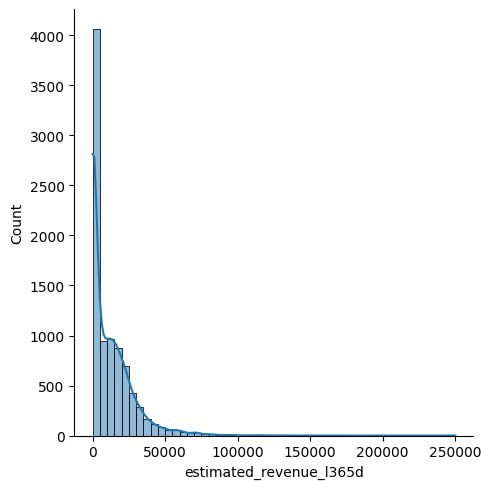

In [17]:
sns.displot(df_drop_revenue_outlier['estimated_revenue_l365d'], kde=True, bins=50)

In [18]:
print(df.estimated_revenue_l365d.describe())
df.sort_values(by='estimated_revenue_l365d', ascending=False).head(5)


count      8898.000000
mean      12210.819285
std       17840.625431
min           0.000000
25%           0.000000
50%        7040.000000
75%       18870.000000
max      684000.000000
Name: estimated_revenue_l365d, dtype: float64


,id,source,neighborhood_overview,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_maximum_nights,maximum_maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,have_description,have_nhoverview,have_host_about,review
10258,967963843443094544,city scrape,NaN,521069057,2023-06-20,"Munich, Germany",within an hour,1.0,99%,t,229.0,306.0,"['email', 'phone']",t,t,Pankow,52.590795,13.378143,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,3.0,"[""Dishes and silverware"", ""Garden view"", ""Bed ...",9000.0,1,365,2.0,365.0,t,29,59,89,364,9,6,0,291,6,76,684000.0,2023-11-19,2024-07-27,4.89,4.89,5.00,4.78,4.78,4.67,4.89,t,1,1,0,0,0.56,True,False,True,present
12652,1234483190089885723,city scrape,"Restaurants: 300 m, Shops: 500 m, Playground: ...",577475069,2024-05-14,NaN,within an hour,1.0,100%,f,467.0,828.0,"['email', 'phone']",t,f,Neukölln,52.416860,13.485230,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,3.0,"[""Bed linens"", ""Refrigerator"", ""TV"", ""Wifi"", ""...",9999.0,1,1125,3.0,1125.0,t,9,11,14,78,3,3,1,78,1,38,379962.0,2024-12-19,2025-03-13,4.33,4.00,4.33,4.33,4.33,5.00,4.67,t,7,7,0,0,1.02,False,True,True,present
12650,1234474294833419521,city scrape,"Bike rental: 1 m, Beach/see/lake: 2.0 km",577475069,2024-05-14,NaN,within an hour,1.0,100%,f,467.0,828.0,"['email', 'phone']",t,f,Charlottenburg-Wilm.,52.494040,13.328170,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,3.0,"[""Heating"", ""Hot water kettle"", ""Freezer"", ""Ga...",10006.0,1,1125,3.0,1125.0,t,17,20,37,221,2,2,1,217,0,25,250150.0,2025-02-06,2025-03-07,5.00,4.50,5.00,5.00,5.00,5.00,4.50,t,7,7,0,0,1.54,False,True,True,present
9887,927212085874367091,city scrape,NaN,102979040,2016-11-08,"Berlin, Germany",within an hour,1.0,83%,f,22.0,29.0,"['email', 'phone']",t,t,Mitte,52.518322,13.383992,Entire rental unit,Entire home/apt,6,2.5,2.5 baths,3.0,3.0,"[""Drying rack for clothing"", ""Dishes and silve...",911.0,92,365,7.0,999.0,t,24,50,66,329,2,2,0,256,2,255,232305.0,2024-09-08,2024-09-12,5.00,5.00,5.00,5.00,5.00,5.00,4.50,t,22,20,0,0,0.32,True,False,True,present
2468,13666450,city scrape,"Close to Tempelhofer Feld, the former capital ...",909226,2011-08-02,"Berlin, Germany",within an hour,1.0,100%,t,13.0,13.0,"['email', 'phone']",t,t,Tempelhof - Schöneberg,52.468660,13.389380,Entire rental unit,Entire home/apt,16,5.0,5 baths,7.0,10.0,"[""Bathtub"", ""Free dryer \u2013 In unit"", ""Dryi...",662.0,2,1125,1125.0,1125.0,t,0,0,0,0,176,23,2,0,27,255,168810.0,2016-10-01,2025-03-02,4.92,4.93,4.85,4.95,4.91,4.64,4.85,t,13,13,0,0,1.71,True,True,True,present


<Axes: xlabel='review_scores_rating', ylabel='estimated_revenue_l365d'>

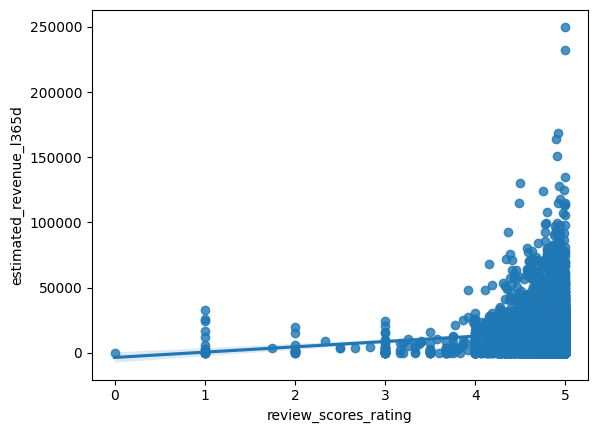

In [19]:
#nonlinear relationship but above 50k starts from rating bigger than 4. again sign of threshold effect
#seabiorn will drop the one without revenue estimation
#xlim to exclude outliers
sns.regplot(x='review_scores_rating', y='estimated_revenue_l365d', data=df_drop_revenue_outlier)


<Axes: xlabel='review_scores_rating', ylabel='estimated_occupancy_l365d'>

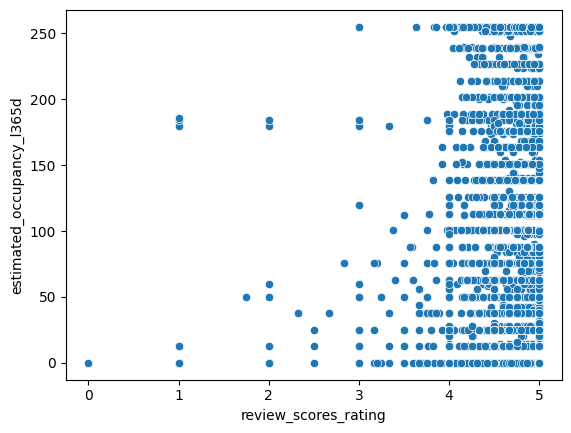

In [20]:
sns.scatterplot(x='review_scores_rating', y='estimated_occupancy_l365d', data=df)

c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\numpy\_core\function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\numpy\_core\function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\seaborn\regression.py:242: RuntimeWarning: invalid value encountered in dot
  return np.linalg.pinv(_x).dot(_y)
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slic

<Axes: xlabel='log_review', ylabel='log_estimated_occupancy_l365d'>

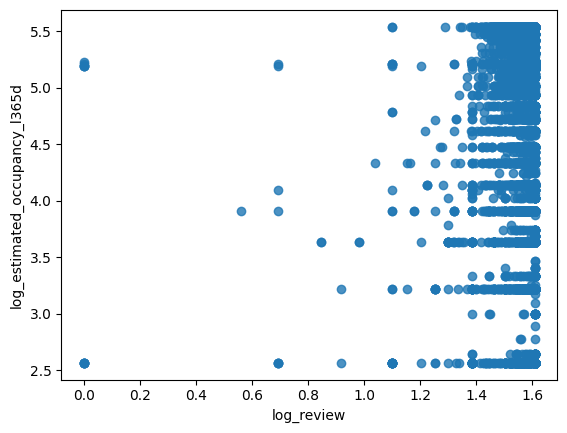

In [21]:
#taking log seeing whether it help, answer is a clear no
df['log_review'] = np.log(df['review_scores_rating'])
df['log_estimated_occupancy_l365d'] = np.log(df['estimated_occupancy_l365d'])
sns.regplot(x='log_review', y='log_estimated_occupancy_l365d', data=df)

<Axes: xlabel='estimated_revenue_l365d', ylabel='estimated_occupancy_l365d'>

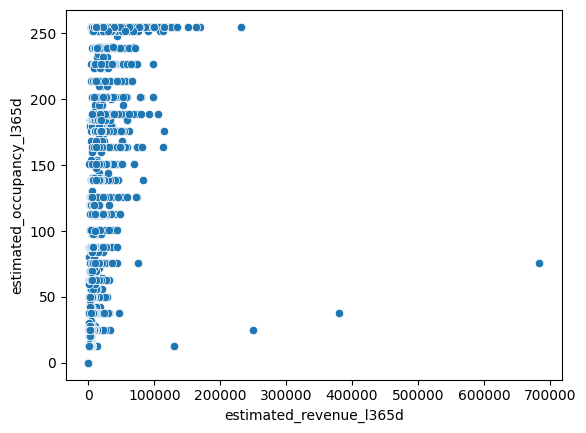

In [22]:
# revenue and occupency also don't have a linear relationship
sns.scatterplot(x='estimated_revenue_l365d', y='estimated_occupancy_l365d', data=df)

(-10000.0, 200000.0)

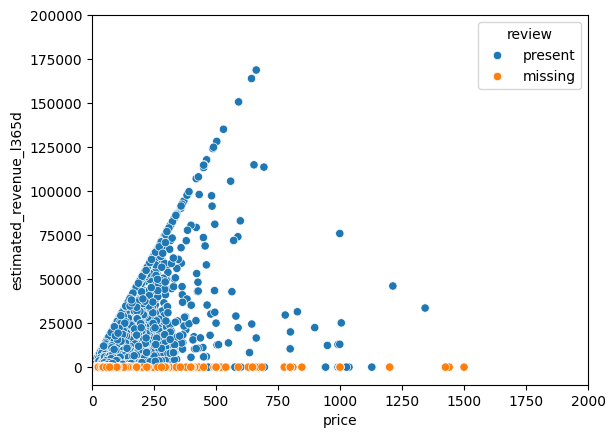

In [ ]:
#i think this graph shows a clear sign of market segmentation, there is a linearity connection between this 2 variables but for each market it has different slope
sns.scatterplot(x='price', y='estimated_revenue_l365d', data=df)
plt.xlim(0, 2000)  # Limit x-axis to focus on lower price range
plt.ylim(-10000, 200000)  # Limit x-axis to focus on lower price range


<Axes: xlabel='price', ylabel='review_scores_value'>

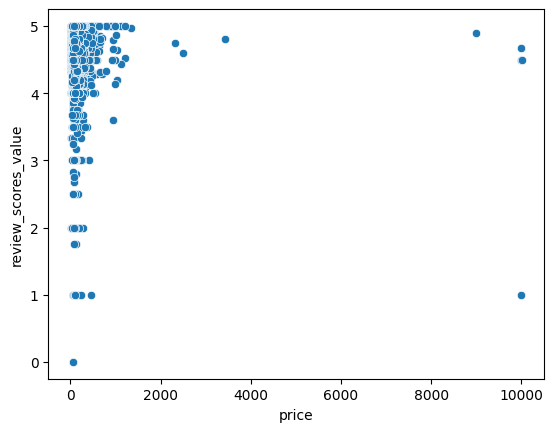

In [24]:
#seems like higher price doesn't mean lower review_scores_value, seems like customer will also take other things into account
df['log_price'] = np.log(df['price'])

sns.scatterplot(x='price', y='review_scores_value', data=df)

2012-07-08 00:00:00 2009-06-20 00:00:00 2008-08-08 00:00:00


<Axes: xlabel='host_experience', ylabel='review_scores_rating'>

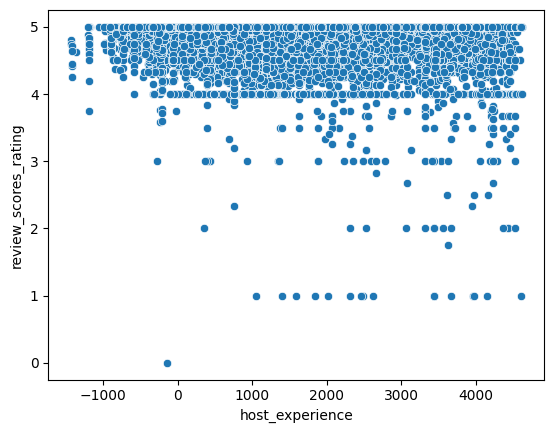

In [ ]:
print(df['last_review'].min(), df['first_review'].min(), df['host_since'].min())
#very old data, using last last_review to gauge scrape time, but scrape could be done at different time, so this might not be an accurate estimation
#need to understand the minus to interpret this graph
last_day = df['last_review'].min()
df['host_experience'] = (df['host_since'] - last_day).dt.days
sns.scatterplot(x='host_experience', y='review_scores_rating', data=df)